In [675]:
import os
import glob
import random

from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms

In [587]:
def _imshow1(_img):
    plt.figure()
    plt.axis("off")

    if len(_img.shape) == 3 and _img.shape[-1] not in {1, 3, 4}:
        return plt.imshow(_img.permute(1, 2, 0))
    plt.imshow(_img, interpolation="nearest")


def imshow(_img, _mask=None):
    if _mask is None:
        return _imshow1(_img)

    _, (ax1, ax2) = plt.subplots(ncols=2)
    ax1.axis("off")
    ax2.axis("off")

    ax1.imshow(_img.permute(1, 2, 0), interpolation="nearest")
    ax2.imshow(_mask, interpolation="nearest")

In [662]:
transform = [
    transforms.ToImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=30, shear=30, translate=(0.25, 0.25)),
    transforms.RandomPerspective(distortion_scale=0.25, p=0.5),
    transforms.RandomErasing(p=0.5),
]

augmentation = [
    transforms.RandomChannelPermutation(),
    transforms.ToDtype(torch.float32, scale=True)
]


class BinaryKeyboardSegmentationDataset(Dataset):
    def __init__(self, _imgs, _transforms=(), _augmentations=()):
        self._images = _imgs
        self._masks = list(map(lambda p: f"blender/masks/keyboard_{os.path.basename(p)[:3]}.png", _imgs))

        self._transforms = transforms.Compose(_transforms)
        self._augmentations = transforms.Compose(_augmentations)

    def __getitem__(self, idx):
        _img = Image.open(self._images[idx])

        _mask = Image.open(self._masks[idx]).convert("RGB")

        _img, _mask = self._transforms(_img, _mask)
        _img = self._augmentations(_img)
        _mask = _mask[0, :, :]
        _mask = (_mask > 1)

        return _img, _mask

    def __len__(self):
        return len(self._images)


In [676]:
image_paths = glob.glob("assets/keyboards/**")
random.shuffle(image_paths)

val_size = int(len(image_paths) * 0.16)
train_size = int(len(image_paths) * 0.8)

val_paths = image_paths[:val_size]
train_paths = image_paths[val_size:train_size]
test_paths = image_paths[train_size:]

train_dataset = BinaryKeyboardSegmentationDataset(train_paths, transform, augmentation)
val_dataset = BinaryKeyboardSegmentationDataset(val_paths, transform, augmentation)
test_dataset = BinaryKeyboardSegmentationDataset(test_paths, transform, augmentation)

len(train_dataset), len(val_dataset), len(test_dataset)

(640, 160, 200)

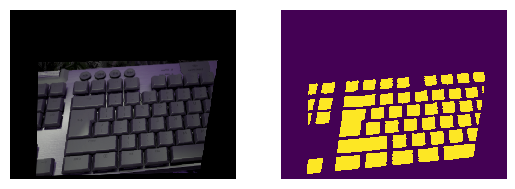

In [677]:
i = random.randint(0, len(train_dataset) - 1)
img, mask = train_dataset[i]

imshow(img, mask)